In [4]:
using Plots, Distributions, LaTeXStrings, ForwardDiff, Random
Random.seed!(1234)

TaskLocalRNG()

## Prueba de concepto de los envelopes 

In [5]:
sigma2 = 1
mu = 0

K = 1/( sqrt( 2 * pi * sigma2)  )
f(x)= exp(- (x - mu)^2/(2 * sigma2) ) #Densidad no normalizada
fnorm(x) = f(x)*K
h(x)= log( f(x)) # Log densidad 
hprime(x) = - (x - mu)/sigma2  # Derivada log densidad
hprime(x) = ForwardDiff.derivative(h,x)

hprime (generic function with 1 method)

In [35]:
function tangent_vectors(h,hprime,X)
    # Calcula los vectores necesarios para las tangentes 
    A = hprime.(X) # Pendiente de las tangentes 
    B = [ h(X[k]) - A[k]*X[k] for k in 1:length(X) ] # Sesgo de las tangentes 
    Z = [ (B[k+1] - B[k])/(A[k] - A[k+1]) for k in 1:length(X)-1  ] |> #interseccion de tangentes
        A-> append!(A,[Inf,-Inf]) |> 
        sort!;
    return A,B,Z
end


function secant_vectors(h,X)
    Hs = h.(X)
    M = [(Hs[k+1] - Hs[k] )/(X[k+1] - X[k]) for k in 1:length(X)-1  ]
    return Hs,M
end

function tangent(x,T,Z,A,B)

    i = searchsortedfirst(Z,x) -1 
    return A[i]*x + B[i]
end

function secant(x,H,M,T)
    if x < first(T) || last(T) < x
        return -Inf
    else
        i= searchsortedfirst(T,x)-1
        return H[i] + M[i] * (x - T[i]) 
    end
    
end

#funcion para calcular el area de la i-esima funcion envolvente
function area(i,A,B,Z)
    Li = Z[i]
    Ri = Z[i+1]
    if A[i] == 0
        return (Ri - Li)*exp(B[i])
    elseif A[i] != 0
        return (exp(A[i]*Ri) - exp(A[i]*Li) )/A[i] * exp(B[i])
    end
end

function mixture_weights(A,B,Z) 
    areas = [ area(i,A,B,Z) for i in 1:length(A)]
    ps = areas ./ sum(areas);
    return ps
end

function cdfinverse(u,i,A,B,Z)
    Li = Z[i]
    Ri = Z[i+1]
    Ai = A[i]

    if A[i] == 0
        return Li + u*(Ri - Li)
    elseif A[i] != 0
        return (1/Ai) * log(u*exp( Ai * Ri) + (1-u)*exp( Ai * Li) )
    end

end


function sample_env(A,B,Z)
    ps = mixture_weights(A,B,Z)
    i = Categorical(ps) |> rand
    U = Uniform() |> rand

    return cdfinverse(U,i,A,B,Z)
end



sample_env (generic function with 1 method)

In [32]:
T = [-2., 0.1 , 2] |> sort; # absicsa
A,B,Z = tangent_vectors(h,hprime,T) 
uk(x) =  tangent(x,T,Z,A,B)


Hs, M = secant_vectors(h,T)
lk(x) = secant(x,Hs,M,T)



lk (generic function with 1 method)

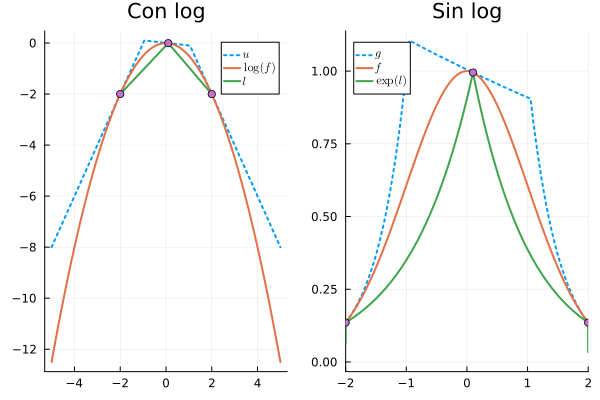

In [28]:
plt = plot(x-> uk(x) |> exp,
    lw=2,
    style=:dot,
    label=L"g")

plot!(x -> h(x) |> exp,
    lw=2,
    label=L"f")

plot!(x -> lk(x) |> exp,
    lw=2,
    label=L"\exp (l)")

scatter!(T, h.(T)|>p -> exp.(p),
    label=""
    )
title!("Sin log")
xlims!(-2,2)

plt_log = plot(x-> uk(x) ,
    lw=2,
    style=:dot,
    label=L"u")

plot!(x -> h(x) ,
    lw=2,
    label=L"\log(f)")

plot!(x -> lk(x) ,
    lw=2,
    label=L"l")

scatter!(T, h.(T),
    label=""
    )
title!("Con log")
final = plot(plt_log,plt)
#savefig(final, "2point-envelope.svg")


In [45]:
smpl = [sample_env(A,B,Z) for _ in 1:1000];

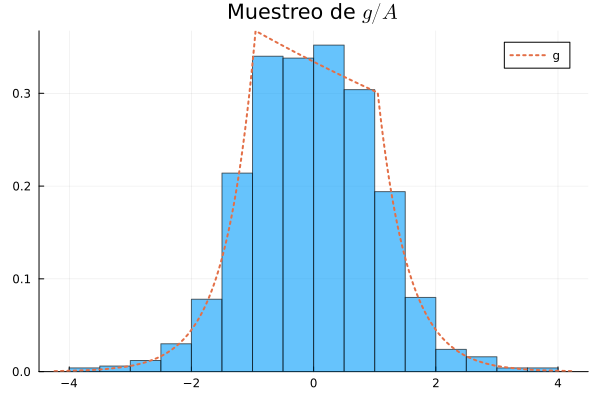

In [46]:
envelope_area = [ area(i,A,B,Z) for i in 1:length(A)] |> sum
normalized_envelope(x) = x |> uk |> exp |> r -> r/envelope_area

plt = histogram(smpl,
    normalize=:pdf,
    label="",
    alpha=0.6)
plot!(normalized_envelope,
    lw=2,
    style=:dot,
    label="g ")
title!(L"Muestreo de $g/A$")
#savefig(plt,"sample-envelope.svg")



In [47]:
#= 
big_T = [-1., 1.5,0.1, -.5, 0.5,-2,2,1, -0.1] # absicsa
ratios = []
#T = [-1., 1.5] # absicsa

for j in 2:length(big_T)
    T = big_T[1:j] |> sort
    k = length(T)

    a = [ hprime(xk) for xk in T] # Pendiente de las tangentes 
    b = [ h(T[k]) - a[k]*T[k] for k in 1:length(T) ] # Sesgo de las tangentes 
    z = [ (b[k+1] - b[k])/(a[k] - a[k+1]) for k in 1:length(T)-1  ] |> #interseccion de tangentes
        A-> append!(A,[Inf,-Inf]) |> 
        sort!;

    areas = [ area(i,a,b,z) for i in 1:length(T)]
    total_area = sum(areas)
    ratio = total_area/(1/K)
    append!(ratios,ratio)
end
=#

In [48]:
#= 
plt = plot([j for j in 2:length(big_T)],log.(ratios),
lw = 2,
label=""
)
xlabel!("k")
ylabel!("Cociente (Escala logaritimica)")
xlims!(2,length(big_T))
savefig(plt,"ratios.svg")
=#

In [49]:
#=
plt = plot(x-> uk(x) |> exp,
    lw=2,
    style=:dot,
    label=L"g")

plot!(x -> h(x) |> exp,
    lw=2,
    label=L"f")

scatter!(T, h.(T)|>p -> exp.(p),
    label=""
    )
title!("Sin log")
xlims!(-2,2)
=#

## Implementacion del ARS

In [ ]:




function ARS(T,h,hprime,N)
    # T: absisas originales
    
    X = T
    A,B,Z = tangent_vectors(h,hprime,X)
    Hs, M = secant_vectors(h,X)

    smpl = []
    n_rejected = 0

    while length(smpl) < N
        accept = false
        x = sample_env(A,B,Z)

        w = Uniform() |> rand

        # squeeze test
        lower = secant(x,Hs,M,X)
        upper =  tangent(x,X,Z,A,B)
        hx = h(x)


        if w <= exp(lower - upper)
            append!(smpl,x)
        else
            if w<= exp(hx - upper)
                append!(smpl,x)
            else
                n_rejected+= 1
            end
            # Update absisas 
            append!(X,x) |> sort!
            A,B,Z = tangent_vectors(h,hprime,X)
            Hs, M = secant_vectors(h,X)
        end

    
    end

    #println("Absisas finales $(length(X))")
    return smpl,X,n_rejected

end



ARS (generic function with 1 method)

In [170]:


mu = 2
theta = 1.

f(x)= sech((x-mu)/(2*theta))^2   #Densidad no normalizada
Logdist = Logistic(mu,theta)

fnorm(x) = pdf(Logdist,x)
h(x)= log( f(x)) # Log densidad 

hprime(x) = ForwardDiff.derivative(h,x)

hprime (generic function with 1 method)

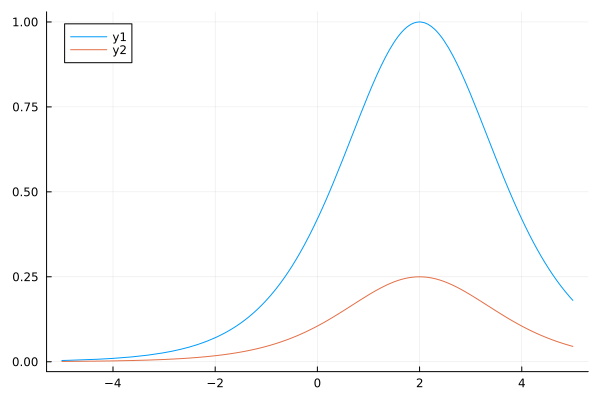

In [171]:
plot(f)
plot!(fnorm)

In [185]:
#T = [-1., 0., 1.5] |> sort # absicsa
T = [-2, 0.1 , 4] |> sort # absicsa


tst, final_absisas, rejected_n = ARS(T,h,hprime,1000);

A,B,Z = tangent_vectors(h,hprime,final_absisas) 
uk(x) =  tangent(x,final_absisas,Z,A,B)


Hs, M = secant_vectors(h,final_absisas)
lk(x) = secant(x,Hs,M,final_absisas)

envelope_area = [ area(i,A,B,Z) for i in 1:length(A)] |> sum
normalized_envelope(x) = x |> uk |> exp |> r -> r/envelope_area

normalized_envelope (generic function with 1 method)

In [187]:
rejected_n

7

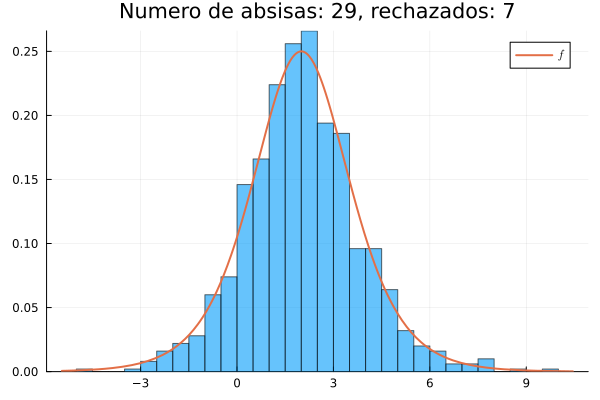

In [173]:
plt = histogram(tst,
    normalize=:pdf,
    label="",
    alpha=0.6) 
plot!(fnorm, label=L"f",lw=2)
title!("Numero de absisas: $(length(final_absisas)), rechazados: $(last(rejected_n))")
#savefig(plt,"ars-example.svg")


## Experimento con forward diff

## Benchmarkeo


In [65]:
using BenchmarkTools

In [66]:
@benchmark ARS($T,$h,$hprime,1000)

BenchmarkTools.Trial: 495 samples with 1 evaluation per sample.
 Range (min … max):  7.909 ms … 34.156 ms  ┊ GC (min … max): 0.00% … 23.48%
 Time  (median):     9.272 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   9.973 ms ±  2.190 ms  ┊ GC (mean ± σ):  7.48% ± 12.22%

      ▁▇ ▃▄▅█▅▃▂                                              
  ▃▃▃███▇████████▄▃▃▂▂▂▃▁▁▃▁▃▃▂▁▁▂▁▁▂▃▂▄▄▄▆▄▄▄▃▃▃▃▁▃▁▁▁▂▁▂▂▃ ▃
  7.91 ms        Histogram: frequency by time        15.4 ms <

 Memory estimate: 6.24 MiB, allocs estimate: 24949.

In [235]:
Nd = Normal(mu,sigma2)
mysampler(size) = rand(Nd,size)

mysampler (generic function with 1 method)

In [236]:
@benchmark mysampler(1000)

BenchmarkTools.Trial: 10000 samples with 10 evaluations per sample.
 Range (min … max):  1.896 μs … 861.638 μs  ┊ GC (min … max):  0.00% … 99.46%
 Time  (median):     2.442 μs               ┊ GC (median):     0.00%
 Time  (mean ± σ):   3.245 μs ±  19.783 μs  ┊ GC (mean ± σ):  22.82% ±  3.95%

           ▅█▆▁                                                
  ▂▅▅▅▄▄▃▄▆████▇▆▅▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂ ▃
  1.9 μs          Histogram: frequency by time        4.85 μs <

 Memory estimate: 7.95 KiB, allocs estimate: 2.

## Algoritmo ARS vs algoritmo 1

In [196]:
using StatsBase
using StatsPlots



In [207]:
@inline sample_sign() = [-1,1]|> rand
@inline uniform_sample() = Uniform() |> rand # Funcion para tomar muestras uniformes de [0,1]
@inline coin_flip() = Bernoulli() |> rand
@inline expo_sample() = Exponential() |> rand

#cota 1 Algoritmo LC-f-m
function g1(x,) 
    return [1, exp(1 - abs(x-m)*M) ] |> minimum |> p-> p*M
end

function algorithmfm(pdf, m)
    #algorithmLC-f-m
    M = pdf(m)
    accept = false
    rejected_n = 0

    while accept == false
        B = coin_flip()
        U = uniform_sample()
        S = sample_sign()

        if B==1
            V = uniform_sample()
            X = m + (S*V)/M
            if U*M <= pdf(X)
                return X, rejected_n
            else 
                rejected_n += 1
            end

        else
            E = expo_sample()
            X = m + S*((1+E)/M)

            if U*M*exp(-E) <= pdf(X)
                return X, rejected_n
            else
                rejected_n += 1 
            end

        end
    end
    return X, rejected_n
end


algorithmfm (generic function with 1 method)

In [208]:
sample_size = 10000
tries = 10

10

In [209]:
sigma2 = 1
mu = 0

K = 1/( sqrt( 2 * pi * sigma2)  )
f(x)= exp(- (x - mu)^2/(2 * sigma2) ) #Densidad no normalizada
fnorm(x) = f(x)*K
h(x)= x |> f |> log # Log densidad 
#hprime(x) = - (x - mu)/sigma2  # Derivada log densidad
hprime(x) = ForwardDiff.derivative(h,x)
m = mu


0

In [210]:

total_rejections_A1 = zeros(tries)

for t in 1:tries
    r_counter = zeros(sample_size)


    for i in 1:sample_size
        r_counter[i] = algorithmfm(f,m) |> last
    end

    total_rejections_A1[t] = r_counter |> sum
end



In [239]:

T = [-2, 0.1 , 4] |> sort # absicsa



total_rejections = zeros(tries)
total_absisas = zeros(tries)

for t in 1:tries
    _, final_absisas, rejected_n = ARS(T,h,hprime,sample_size);
    total_rejections[t] = rejected_n
    total_absisas[t] = final_absisas |> length
end



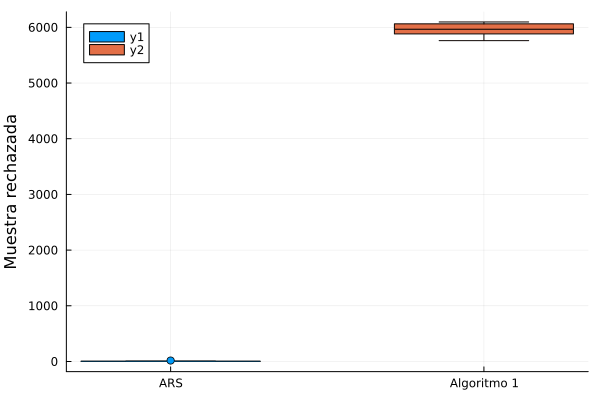

In [214]:
boxplot(["ARS" "Algoritmo 1"], [total_rejections total_rejections_A1])
ylabel!("Muestra rechazada")

In [215]:
total_rejections |> summarystats

Summary Stats:
Length:         10
Missing Count:  0
Mean:           4.600000
Std. Deviation: 4.550946
Minimum:        1.000000
1st Quartile:   2.250000
Median:         3.500000
3rd Quartile:   4.750000
Maximum:        17.000000


In [216]:
total_rejections_A1 |> summarystats

Summary Stats:
Length:         10
Missing Count:  0
Mean:           5964.000000
Std. Deviation: 110.712842
Minimum:        5761.000000
1st Quartile:   5882.000000
Median:         5965.500000
3rd Quartile:   6062.500000
Maximum:        6096.000000


In [240]:
total_absisas |> summarystats

Summary Stats:
Length:         10
Missing Count:  0
Mean:           105.500000
Std. Deviation: 21.869563
Minimum:        67.000000
1st Quartile:   91.000000
Median:         108.000000
3rd Quartile:   122.750000
Maximum:        133.000000


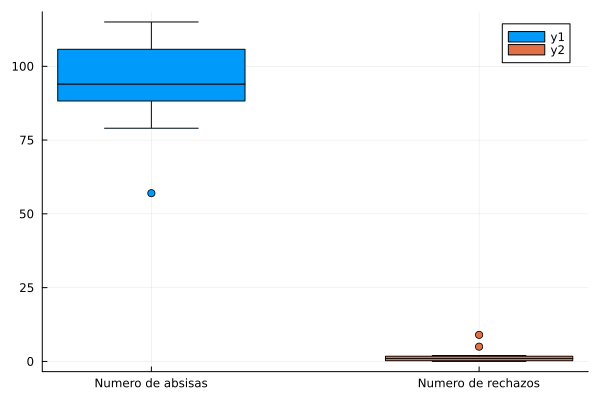

In [195]:
using StatsPlots
boxplot(["Numero de absisas" "Numero de rechazos"], [total_absisas total_rejections])

In [226]:
sampler1() = algorithmfm(f,m) |> first

sampler1 (generic function with 1 method)

In [231]:
samplerN(N) = [sampler1() for _ in 1:N ]

samplerN (generic function with 1 method)

In [234]:
@benchmark algorithmfm($f,$m)

BenchmarkTools.Trial: 10000 samples with 199 evaluations per sample.
 Range (min … max):  437.814 ns …  42.198 μs  ┊ GC (min … max): 0.00% … 98.38%
 Time  (median):     498.533 ns               ┊ GC (median):    0.00%
 Time  (mean ± σ):   543.539 ns ± 957.936 ns  ┊ GC (mean ± σ):  7.65% ±  4.51%

                ▁▂▃▆▆▅█▇▇█▆▆▆▄▂▂▁▁                               
  ▁▁▁▁▁▂▂▂▂▄▄▅▆▇███████████████████▇▆▄▅▄▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁ ▄
  438 ns           Histogram: frequency by time          595 ns <

 Memory estimate: 443 bytes, allocs estimate: 21.

In [237]:
@benchmark samplerN(10000)

BenchmarkTools.Trial: 865 samples with 1 evaluation per sample.
 Range (min … max):  5.084 ms … 15.448 ms  ┊ GC (min … max): 0.00% … 26.83%
 Time  (median):     5.370 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   5.775 ms ±  1.117 ms  ┊ GC (mean ± σ):  6.48% ± 11.83%

  ▁▁▆█▇▅▃▃▂                                       ▁▂          
  ██████████▇▅▆▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▄▄▆███▇█▆▆▆█▇ █
  5.08 ms      Histogram: log(frequency) by time     9.11 ms <

 Memory estimate: 5.00 MiB, allocs estimate: 250232.

In [233]:
@benchmark ARS($T,$h,$hprime,1000)

BenchmarkTools.Trial: 499 samples with 1 evaluation per sample.
 Range (min … max):  8.348 ms … 17.992 ms  ┊ GC (min … max): 0.00% … 53.13%
 Time  (median):     9.181 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   9.922 ms ±  1.880 ms  ┊ GC (mean ± σ):  8.33% ± 13.15%

    ▄▄█▃▄▄▅▁▂                                                 
  ▄▇██████████▅▅▃▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▁▁▃▃▃▄▃▅▅▃▄▃▃▃▁▃▃▂▂ ▃
  8.35 ms        Histogram: frequency by time        14.9 ms <

 Memory estimate: 7.03 MiB, allocs estimate: 25453.